Notebook where we perform the spatial similarity analysis between task-based patterns both at the group and subject level

In [9]:
from nilearn.image import load_img
import tqdm

from nilearn import image

from nilearn.masking import apply_mask, unmask
from scipy.spatial.distance import squareform
import bct
from scipy.stats import norm
from statsmodels.stats.multitest import  multipletests
from scipy.stats import ttest_1samp
from scipy.spatial.distance import dice

plt.rcParams['font.family'] = ['arial']

atlas_img = image.load_img("../data/atlases/shen_2mm_268_parcellation.nii.gz")

In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)
print(n_subjects)

242


# Similarities at group-level

In [3]:
### Load contrast effect sizes at subject level

## EDGE
pattern = "../results/first-level/nogsr/edge/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_edge_ef = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef.append(stroop_edge_data)
stroop_edge_ef = np.array(stroop_edge_ef)

pattern = "../results/first-level/nogsr/edge/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_edge_ef = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef.append(msit_edge_data)
    
msit_edge_ef = np.array(msit_edge_ef)

## NODE
pattern = "../results/first-level/nogsr/node_roi/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/nogsr/node_roi/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

In [4]:
print(stroop_node_ef.shape, "", msit_node_ef.shape)
print(stroop_edge_ef.shape, "", msit_edge_ef.shape)

(242, 268)  (242, 268)
(242, 35778)  (242, 35778)


In [5]:
### Compute group level maps

## EDGE
edge_stroop_group, p_edge_stroop = np.apply_along_axis(ttest_1samp, 0, stroop_edge_ef, popmean=0)
edge_msit_group, p_edge_msit = np.apply_along_axis(ttest_1samp, 0, msit_edge_ef, popmean=0)

## NODE
node_stroop_group, p_node_stroop = np.apply_along_axis(ttest_1samp, 0, stroop_node_ef, popmean=0)
node_msit_group, p_node_msit = np.apply_along_axis(ttest_1samp, 0, msit_node_ef, popmean=0)

In [6]:
# Spearman similarities between unthresholded maps
r, _ = stats.spearmanr(edge_stroop_group, edge_msit_group)

print("EDGE T-similarity: ", r)

r, _ = stats.spearmanr(node_stroop_group, node_msit_group)

print("NODE T-similarity: ", r)

EDGE T-similarity:  0.60832342436587
NODE T-similarity:  0.8802902907458448


## Plot group-level activation maps

In [7]:
def map_on_atlas(stat_data, atlas_img):
    """
    Function to map a statistical map
    """
    from nilearn import image
    atlas_img = image.load_img(atlas_img)
    n_rois = len(np.unique(atlas_img.get_fdata()))-1
    stat_data = np.squeeze(stat_data)
    if stat_data.ndim > 1:
        raise ValueError("input stat data should be a vector")
    if len(stat_data) != n_rois:
        raise ValueError("stat componentes do not match"
                         " the number of ROIS of the atlas")
    atlas_img_data = atlas_img.get_fdata()
    stat_on_atlas = np.zeros_like(atlas_img_data)
    
    for ii in range(n_rois):
        stat_on_atlas[atlas_img_data==(ii+1)] = stat_data[int(ii)]
    
    stat_on_atlas_img = image.new_img_like(atlas_img, stat_on_atlas)
    return stat_on_atlas_img

/tmp/ipykernel_4068611/69936327.py:10: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template(),


Text(0.5, 1.05, 't-stat')

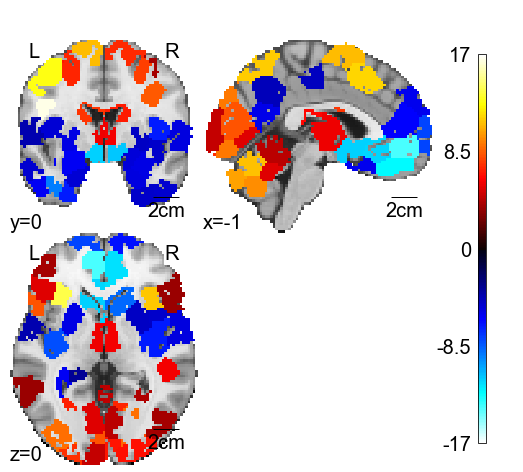

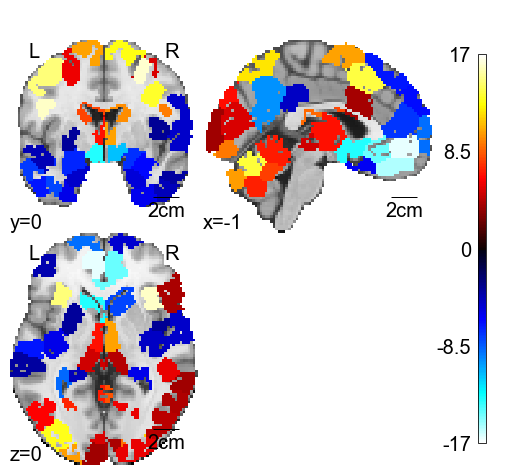

In [10]:
from nilearn import plotting
from nilearn.datasets import load_mni152_template
from statsmodels.stats.multitest import multipletests

mask = multipletests(p_node_stroop, method='holm')[0]
display = plotting.plot_img(map_on_atlas(node_stroop_group*mask, atlas_img),
                            cmap=plotting.cm.cold_hot,
                            display_mode='tiled', 
                            cut_coords = (-1,0,0),
                            bg_img = load_mni152_template(), 
                            draw_cross=False, black_bg=False,
                            threshold=1e-6, colorbar=True, 
                            vmin=-17, vmax=17)
display.annotate(size=20, scalebar=True, scale_size=2)
display._colorbar_ax.yaxis.set_tick_params(width=0, labelsize=20)
display._colorbar_ax.set_title("t-stat", {'color':'w', 'fontsize':30}, loc="center", y=1.05)
#display.title("Stroop", x=0.5, y=0.3, size=60, color='k', bgcolor='w')

mask = multipletests(p_node_msit, method='holm')[0]
display = plotting.plot_img(map_on_atlas(node_msit_group*mask, atlas_img),
                            cmap=plotting.cm.cold_hot,
                            display_mode='tiled', 
                            cut_coords = (-1,0,0),
                            bg_img = load_mni152_template(), 
                            draw_cross=False, black_bg=False,
                            threshold=1e-6, colorbar=True, 
                            vmin=-17, vmax=17)
display.annotate(size=20, scalebar=True, scale_size=2)
display._colorbar_ax.yaxis.set_tick_params(width=0, labelsize=20)
display._colorbar_ax.set_title("t-stat", {'color':'w', 'fontsize':30}, loc="center", y=1.05)
#display.title("MSIT", x=0.5, y=0.3, size=60, color='k', bgcolor='w')

In [11]:
# Dice similarities betweeen binarized maps
n_rois = len(p_node_stroop)
thr = 0.05/n_rois

print(f"threshold: {thr}")
print(f"NODE DSC: {1-dice(p_node_stroop<thr, p_node_msit<thr)}")
print(f"EDGE DSC: {1-dice(p_edge_stroop<thr, p_edge_msit<thr)}")

n_links = len(p_edge_stroop)
thr = 0.05/n_links

print(" ")
print(f"threshold: {thr}")
print(f"NODE DSC: {1-dice(p_node_stroop<thr, p_node_msit<thr)}")
print(f"EDGE DSC: {1-dice(p_edge_stroop<thr, p_edge_msit<thr)}")

threshold: 0.00018656716417910448
NODE DSC: 0.8201892744479495
EDGE DSC: 0.11633372502937722
 
threshold: 1.3975068477835543e-06
NODE DSC: 0.8
EDGE DSC: 0.08807733619763691


## GROUP-LEVEL

In [12]:
# Spearman similarity between tasks varying the number of subjects

from scipy.stats import spearmanr

rng = np.random.RandomState(0)
n_shuffles = 10
n_points = 10
thresholds = [1e-6, 1e-4, 1e-2]
n_thr = len(thresholds)

or_node, or_edge = np.zeros(shape=(n_thr, n_points, n_shuffles)), np.zeros(shape=(n_thr, n_points, n_shuffles))
cors_node, cors_edge = np.zeros(shape=(n_points, n_shuffles)), np.zeros(shape=(n_points, n_shuffles))

for ii, prop in tqdm.tqdm(enumerate(np.linspace(0.1, 1, 10))):
    for jj, shuffle in enumerate(range(n_shuffles)):
        idxs_shuffle = rng.choice(np.arange(n_subjects), size=n_subjects, replace=False)
        idxs_sub = idxs_shuffle[:int(prop*n_subjects)]

        t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_node_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp,
                                                       axis=0, 
                                                       arr=msit_node_ef[idxs_sub,:], 
                                                       popmean=0)

        t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_edge_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=msit_edge_ef[idxs_sub,:], 
                                                       popmean=0)

        # Correlations
        cors_node[ii,jj] = spearmanr(t_node_stroop, t_node_msit)[0]
        cors_edge[ii,jj] = spearmanr(t_edge_stroop, t_edge_msit)[0]
        
        for kk, alpha in enumerate(thresholds):
            or_node[kk,ii,jj] = 1-dice(p_node_stroop<alpha, p_node_msit<alpha)
            or_edge[kk,ii,jj] = 1-dice(p_edge_stroop<alpha, p_edge_msit<alpha)

0it [00:00, ?it/s]/home/javi/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:1420: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
10it [14:17, 85.77s/it]


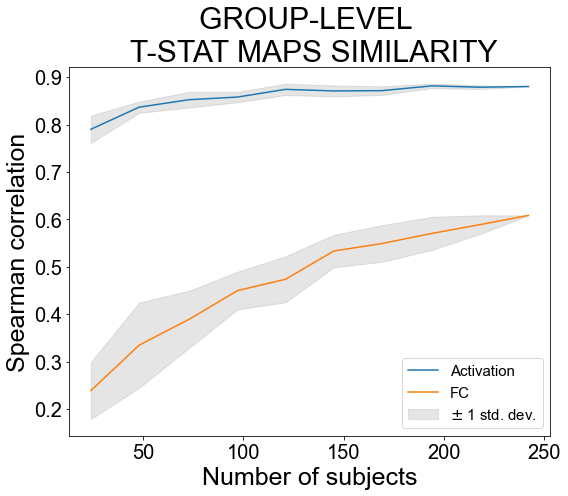

In [13]:
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8,7))

mean_ = np.mean(cors_node, axis=1)
std_ = np.std(cors_node, axis=1)

ax.plot(xticks, mean_, label = "Activation")

ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

mean_ = np.mean(cors_edge, axis=1)
std_ = np.std(cors_edge, axis=1)

ax.plot(xticks, mean_, label = "FC")
ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2)
ax.legend()
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n T-STAT MAPS SIMILARITY", size=30)
ax.legend(fontsize=15)
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/supplementary/similarity_analysis_roi_nogsr.png", dpi=300)
plt.savefig("../plots/supplementary/similarity_analysis_roi_nogsr.svg", dpi=300)
plt.savefig("../plots/supplementary/similarity_analysis_roi_nogsr.pdf", dpi=300)

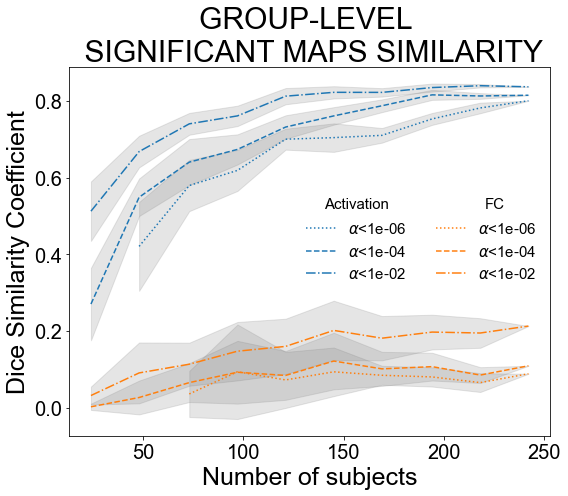

In [22]:
# Overlapping analysis between tasks using the DICE coefficient, varying the number of subjects and thresholds
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8, 7))

mean_ = np.mean(or_node, axis=2)
std_ = np.std(or_node, axis=2)

for (kk, alpha), lstyle  in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha, 
                c="C0", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

mean_ = np.mean(or_edge, axis=2)
std_ = np.std(or_edge, axis=2)

for (kk, alpha), lstyle in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha,
                c="C1", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

ax.legend(fontsize=15, ncol=2, frameon=False)
ax.set_ylabel("Dice Similarity Coefficient", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n SIGNIFICANT MAPS SIMILARITY", size=30)

ax.text(x=140, y=0.52, s="Activation", size=15)
ax.text(x=220, y=0.52, s="FC", size=15)

ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/supplementary/overlapping_analysis_roi_nogsr.png", dpi=300)
plt.savefig("../plots/supplementary/overlapping_analysis_roi_nogsr.svg", dpi=300)
plt.savefig("../plots/supplementary/overlapping_analysis_roi_nogsr.pdf", dpi=300)

## SUBJECT LEVEL

In [15]:
# Distributions of similarities at subject level
sims_node = [spearmanr(a,b)[0] for a, b in zip(stroop_node_ef, msit_node_ef)]
sims_edge = [spearmanr(a,b)[0] for a, b in zip(stroop_edge_ef, msit_edge_ef)]

In [16]:
print(np.mean(sims_node))
print(np.mean(sims_edge))

0.3046615841057026
0.04643531910968383


In [17]:
from scipy.stats import ttest_rel
ttest_rel(sims_node, sims_edge)

Ttest_relResult(statistic=18.569532773051552, pvalue=2.1934038607360125e-48)

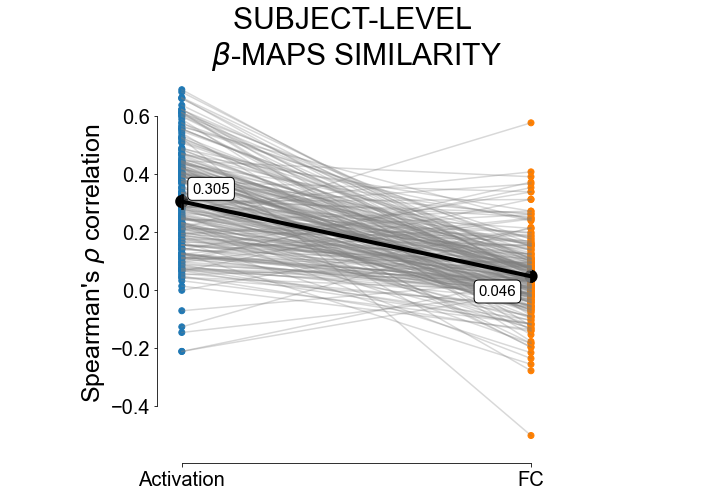

In [18]:
fig, ax= plt.subplots(figsize=(10,7))

for x,y in zip(sims_node, sims_edge):
    ax.scatter([0,1], [x, y], c=[sns.color_palette("Paired")[1], 
                                  sns.color_palette("Paired")[7]])
    if x>y:
        c="grey"   
    else:
        c="grey"
        
    ax.plot([0,1], [x, y], color=c, alpha=0.3)
    
sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(pd.DataFrame({'node':sims_node, 'edge':sims_edge})), color='black',
              ax=ax)
ax.set_ylabel(r"Spearman's $\rho$ correlation", size=25)
ax.set_xticklabels(["Activation", "FC"], size=20)
ax.set_xlabel("")
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-MAPS SIMILARITY", size=30)
sns.despine(offset={'bottom':10, 'left':-150}, trim=True)

ax.annotate(np.round(np.mean(sims_node), 3), 
                xy=[0+ 0.03, np.mean(sims_node) + 0.03], 
                size=15, bbox = dict(boxstyle="round", fc="1.0"))

ax.annotate(np.round(np.mean(sims_edge), 3), 
            xy=[0.85, -0.02], 
            size=15, bbox = dict(boxstyle="round", fc="1.0"))

plt.tight_layout()
plt.savefig("../plots/supplementary/subject_level_betas_similarity_analysis_roi_nogsr.png", dpi=300)
plt.savefig("../plots/supplementary/subject_level_betas_similarity_analysis_roi_nogsr.svg", dpi=300)
plt.savefig("../plots/supplementary/subject_level_betas_similarity_analysis_roi_nogsr.pdf", dpi=300)

In [19]:
import dabest
dabest.load(pd.DataFrame({'activation': sims_node, 'FC': sims_edge, 'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "FC"), id_col='id', paired=True).cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,activation,FC,242,242,Cohen's d,True,-1.690802,95,-1.903739,-1.44433,0.0,3.680866e-34,1417.0,2.193404e-48,18.569533


In [20]:
dabest.effsize.cohens_d(control=sims_edge, test=sims_node, is_paired=True)

1.6908017707420722

### Generate files to plot in profiles using circos

In [50]:
# Atlas
atlas_img = image.load_img("../data/atlases/shen_2mm_268_parcellation.nii.gz")
shen_rsns = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv")

rsn_ids = np.sort(shen_rsns.Network.unique())

# Order according to network id in increasing order
shen_rsns = shen_rsns.sort_values("Network")
shen_rsns.head()

network_regions = dict()
for ii in rsn_ids:
    network_regions[ii] = shen_rsns[shen_rsns.Network == ii]['Node'].to_list()
#print(network_regions)

network_ids = dict()
for ii, net_id in zip(rsn_ids, ['mf', 'fp', 'dm','sc', 'mt', 'v1', 'v2', 'va']):
    network_ids[ii] = net_id
#print(network_ids)

network_labels = dict()
for ii, net_label in zip(rsn_ids, 
                      ['medial-frontal', 'frontoparietal', 'default-mode','subcortical-cerebellum',
                       'motor', 'visual-1', 'visual-2', 'visual-association']):
    network_labels[ii] = net_label
#print(network_labels)

# Add colours to each network (R, G, B)
rsn_colors = [[128,0,128], [0,255,255], [255,215,0], [255,69,0],
              [0,0,128], [255,0,255], [0,255,0], [128,0,0]
             ]

network_colors = dict()
for ii, color in zip(rsn_ids, rsn_colors):
    network_colors[ii] = color
#print(network_colors)

# place everything in the same dictionary
network_info = dict()
for ii in rsn_ids:
    net_dict = dict()
    
    net_dict['regions'] = network_regions[ii]
    net_dict['id'] = network_ids[ii]
    net_dict['label'] = network_labels[ii]
    net_dict['color'] = network_colors[ii]
    net_dict['start'] = 0
    net_dict['end'] = len(network_regions[ii])*100 -1
    
    network_info[ii] = net_dict

    
nodes_info = dict()
for rsn_id in network_info:
    network_dict = network_info[rsn_id]
    
    start = 0
    end = 99
    for ii, region_id in enumerate(network_dict['regions']):
        parent_id = network_dict['id']
        reg_id = network_dict['id'] + "_" + str(ii+1)
        reg_label = network_dict['id'] + "-" + str(ii+1)
        color_id = network_dict['id'] + "_color_" + str(ii+1)
        nodes_info[region_id] = {'id': reg_id, 
                                 'label': reg_label, 
                                 'start': start, 
                                 'end': end, 
                                 'color_id': color_id, 
                                 'color_rgb': network_dict['color'], 
                                 'parent_id': parent_id}
        start += 100
        end += 100

print(nodes_info)

{165: {'id': 'mf_1', 'label': 'mf-1', 'start': 0, 'end': 99, 'color_id': 'mf_color_1', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 53: {'id': 'mf_2', 'label': 'mf-2', 'start': 100, 'end': 199, 'color_id': 'mf_color_2', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 52: {'id': 'mf_3', 'label': 'mf-3', 'start': 200, 'end': 299, 'color_id': 'mf_color_3', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 148: {'id': 'mf_4', 'label': 'mf-4', 'start': 300, 'end': 399, 'color_id': 'mf_color_4', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 194: {'id': 'mf_5', 'label': 'mf-5', 'start': 400, 'end': 499, 'color_id': 'mf_color_5', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 149: {'id': 'mf_6', 'label': 'mf-6', 'start': 500, 'end': 599, 'color_id': 'mf_color_6', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 192: {'id': 'mf_7', 'label': 'mf-7', 'start': 600, 'end': 699, 'color_id': 'mf_color_7', 'color_rgb': [128, 0, 128], 'parent_id': 'mf'}, 162: {'id': 'mf_8', 'label': 'mf-8', 'start':

In [53]:
# generate histograms with
from sklearn.preprocessing import maxabs_scale
from statsmodels.stats.multitest import multipletests

t, p = edge_stroop_group, p_edge_stroop

is_sig = multipletests(p, method="bonferroni")[0]
is_sig_mat = squareform(is_sig)
is_sig_degree = list(np.sum(is_sig_mat, axis = 1))

Path("../plots/supplementary/circos_nogsr/data").mkdir(exist_ok=True, parents=True)
filename = "../plots/supplementary/circos_nogsr/data/histo_stroop.txt"
with open(filename, "w") as f:
     for node_key, node_dict in nodes_info.items():
            parent_id = node_dict['parent_id']
            start = node_dict['start']
            end = node_dict['end']
            value = is_sig_degree[node_key-1]

            hm_line = "%s %d %d %d\n" % (parent_id, start, end, value)
            f.writelines(hm_line)
            
t_corrected = squareform(maxabs_scale(edge_stroop_group*is_sig), checks=False)
is_sig_mat[np.tril_indices_from(is_sig_mat)] = False

source_ixs, target_ixs = np.where(is_sig_mat)
filename ="../plots/supplementary/circos_nogsr/data/links_stroop.txt"
with open(filename, "w") as f:
    for six, tix in zip(source_ixs, target_ixs):
        source_reg = nodes_info[six + 1] # Nodes start from 1 to 268
        target_reg = nodes_info[tix + 1]
        score = t_corrected[six, tix]
        if score > 0:
            link_type = 1
        else:
            link_type = 0
        link_line = "%s %d %d %s %d %d type=%s,score=%.5f\n" % (source_reg['parent_id'], source_reg['start'], source_reg['end'],
                                                                 target_reg['parent_id'], target_reg['start'], target_reg['end'],
                                                                 link_type, abs(score))
        f.writelines(link_line)

In [55]:
from sklearn.preprocessing import maxabs_scale
from statsmodels.stats.multitest import multipletests

t, p = edge_msit_group, p_edge_msit

is_sig = multipletests(p, method="bonferroni")[0]
is_sig_mat = squareform(is_sig)
is_sig_degree = list(np.sum(is_sig_mat, axis = 1))

Path("../plots/supplementary/circos_nogsr/data").mkdir(exist_ok=True, parents=True)
filename = "../plots/supplementary/circos_nogsr/data/histo_msit.txt"
with open(filename, "w") as f:
     for node_key, node_dict in nodes_info.items():
            parent_id = node_dict['parent_id']
            start = node_dict['start']
            end = node_dict['end']
            value = is_sig_degree[node_key-1]

            hm_line = "%s %d %d %d\n" % (parent_id, start, end, value)
            f.writelines(hm_line)
            
t_corrected = squareform(maxabs_scale(edge_stroop_group*is_sig), checks=False)
is_sig_mat[np.tril_indices_from(is_sig_mat)] = False

source_ixs, target_ixs = np.where(is_sig_mat)
filename ="../plots/supplementary/circos_nogsr/data/links_msit.txt"
with open(filename, "w") as f:
    for six, tix in zip(source_ixs, target_ixs):
        source_reg = nodes_info[six + 1] # Nodes start from 1 to 268
        target_reg = nodes_info[tix + 1]
        score = t_corrected[six, tix]
        if score > 0:
            link_type = 1
        else:
            link_type = 0
        link_line = "%s %d %d %s %d %d type=%s,score=%.5f\n" % (source_reg['parent_id'], source_reg['start'], source_reg['end'],
                                                                 target_reg['parent_id'], target_reg['start'], target_reg['end'],
                                                                 link_type, abs(score))
        f.writelines(link_line)